In [9]:
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt

# Import

First we open a file containing a dictionary of columns and associated data types generated in `../../optimize/`, then we read input file.

In [10]:
with open('../input/dtypes.yaml', 'r') as yamlfile:
    column_types = yaml.load(yamlfile)

read_csv_opts = {'sep': '|',
                 'quotechar': '"',
                 'compression': 'gzip',
                 'encoding': 'utf-8',
                 'dtype': column_types,
                 'parse_dates': ['MissionDate'],
                 'infer_datetime_format': True}

df = pd.read_csv('../input/ice-air.csv.gz', **read_csv_opts)

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763020 entries, 0 to 1763019
Data columns (total 44 columns):
Status                  category
Sex                     category
Convictions             category
GangMember              category
ClassLvl                float32
Age                     float32
MissionDate             datetime64[ns]
MissionNumber           uint32
PULOC                   category
DropLoc                 category
StrikeFromList          float32
ReasonStruck            category
R-T                     category
Code                    category
CountryOfCitizenship    category
Juvenile                bool
MissionWeek             uint8
MissionQuarter          uint8
MissionYear             uint16
MissionMonth            uint8
Criminality             category
FamilyUnitFlag          float32
UnaccompaniedFlag       float32
AlienMasterID           uint32
MissionID               uint16
air_AirportID           float32
air_AirportName         category
air_City         

In [11]:
with open('../input/airport_dict.yaml', 'r') as yamlfile:
    airport_dict = yaml.load(yamlfile)

# Airport report

For a given airport ICAO code represented in the ICE Air data, output a uniform set of variables, tables, and figures.

In [153]:
airport = 'KBFI'
if airport.upper() in airport_dict.keys():
    pass
else:
    print(f'{airport} not represented in dataset')
airport_name = airport_dict[airport]
pickup = df['PULOC'] == airport
dropoff = df['DropLoc'] == airport

pickup_df = df[pickup]
dropoff_df = df[dropoff]

first_pickup = pickup_df.MissionDate.min()
last_pickup = pickup_df.MissionDate.max()
first_dropoff = dropoff_df.MissionDate.min()
last_dropoff = dropoff_df.MissionDate.max()

pickup_df.set_index('MissionDate', inplace=True)
dropoff_df.set_index('MissionDate', inplace=True)

# pickup_df.to_csv(f'../output/{airport}_pickups.csv')
# dropoff_df.to_csv(f'../output/{airport}_dropoffs.csv')

all_df = pd.concat([pickup_df, dropoff_df]).drop_duplicates()

# This grouped table would work for mapping flights from specific airports.
all_missions = all_df.groupby(['MissionDate', 'MissionID', 'PULOC', 'DropLoc'])[['AlienMasterID', 'MissionID']].nunique()
# all_missions = all_missions.reset_index()
all_missions.to_csv(f'../output/{airport}_all_missions.csv')

In [154]:
weekly_pickups = pickup_df['AlienMasterID'].resample('W').nunique()
weekly_dropoffs = dropoff_df['AlienMasterID'].resample('W').nunique()
monthly_pickups = pickup_df['AlienMasterID'].resample('M').nunique()
monthly_dropoffs = dropoff_df['AlienMasterID'].resample('M').nunique()
monthly_pickup_flights = pickup_df['MissionID'].resample('M').nunique()
monthly_dropoff_flights = dropoff_df['MissionID'].resample('M').nunique()
annual_pickups = pickup_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_dropoffs = dropoff_df['AlienMasterID'].resample('AS-OCT').nunique()
annual_pickup_flights = pickup_df['MissionID'].resample('AS-OCT').nunique()
annual_dropoff_flights = dropoff_df['MissionID'].resample('AS-OCT').nunique()

In [155]:
print(f'{airport} ({airport_name})')
print(f'---------------------------------------------------------')
unique_pickups = len(set(pickup_df['AlienMasterID']))
unique_dropoffs = len(set(dropoff_df['AlienMasterID']))
print(f'{unique_pickups} passengers picked up, {unique_dropoffs} passengers dropped off.')
print(f"{all_df['AlienMasterID'].nunique()} total unique passengers.")
print(f'{round(monthly_dropoffs.mean(), 2)} average dropoffs per month.')
print(f'{round(monthly_pickups.mean(), 2)} average pickups per month.')
print()
unique_pickup_flights = len(set(pickup_df['MissionID']))
unique_dropoff_flights = len(set(dropoff_df['MissionID']))
print(f'{unique_pickup_flights} pickup flights, {unique_dropoff_flights} dropoff flights.')
print(f"{all_df['MissionID'].nunique()} total missions.")
print(f'{round(monthly_dropoff_flights.mean(), 2)} average dropoff flights per month.')
print(f'{round(monthly_pickup_flights.mean(), 2)} average pickup flights per month.')
print(f'First pickup flight: {first_pickup}; Last pickup flight: {last_pickup}')
print(f'First dropoff flight: {first_dropoff}; Last dropoff flight: {last_dropoff}')

KBFI (Boeing Field King County International Airport)
---------------------------------------------------------
34443 passengers picked up, 15191 passengers dropped off.
49634 total unique passengers.
153.44 average dropoffs per month.
347.91 average pickups per month.

466 pickup flights, 371 dropoff flights.
514 total missions.
3.75 average dropoff flights per month.
4.71 average pickup flights per month.
First pickup flight: 2010-10-02 00:00:00; Last pickup flight: 2018-12-04 00:00:00
First dropoff flight: 2010-10-02 00:00:00; Last dropoff flight: 2018-12-04 00:00:00


# Annual trends (by fiscal year)

In [142]:
annual_pickups.rename('Total pickups', inplace=True)
annual_pickups

MissionDate
2011-10-01    7
Freq: AS-OCT, Name: Total pickups, dtype: int64

In [143]:
annual_dropoffs.rename('Total dropoffs', inplace=True)
annual_dropoffs

Series([], Freq: AS-OCT, Name: Total dropoffs, dtype: uint32)

In [138]:
annual_pickup_flights.rename('Total pickup flights', inplace=True)
annual_pickup_flights

MissionDate
2010-10-01    2
2011-10-01    2
Freq: AS-OCT, Name: Total pickup flights, dtype: int64

In [103]:
annual_dropoff_flights.rename('Total dropoff flights', inplace=True)
annual_dropoff_flights

Series([], Freq: AS-OCT, Name: Total dropoff flights, dtype: uint16)

In [104]:
annual_summary = pd.DataFrame({'Annual Pickups': annual_pickups,
              'Annual Pickup Flights': annual_pickup_flights,
              'Annual Dropoffs': annual_dropoffs,
             ' Annual Pickup Flights': annual_dropoff_flights,})

In [105]:
annual_summary.index = annual_summary.index.year+1 
annual_summary.index.name = 'FiscalYear'

In [106]:
annual_summary.to_csv(f'../output/{airport}_annual_summary.csv')

In [107]:
sum(annual_pickup_flights) + sum(annual_dropoff_flights)

1

TypeError: Empty 'DataFrame': no numeric data to plot

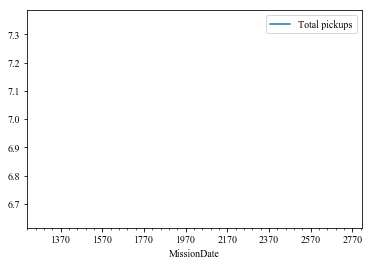

In [108]:
def pickup_dropoff_trend(data):
    
    fig, ax = plt.subplots()
    
    for datum in data:
        ax = datum.plot(legend=True)
    
    ax.set_ylabel('Number of Passengers', fontsize=16)
    ax.set_ylim(0)
    ax.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2010,2019)])
    ax.set_xlabel('Fiscal Year', fontsize=16)
    ax.set_title(f'{airport_name}', fontsize=18)
    ax.tick_params(labelsize=14)
    ax.legend(fontsize=14)
    
    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{airport}-ICE-Air-Passengers.png', dpi=100)
    return fig, ax

plot = pickup_dropoff_trend([annual_pickups['2010':'2017'], annual_dropoffs['2010':'2017']]);

# Annual pickup rate, by criminal conviction status

WARNING: Criminal conviction data is not consistently recorded by ICE, especially in FY 11.

In [109]:
annual_non_criminal = pickup_df[['NonCriminal']].resample('AS-OCT').sum()

In [110]:
annual_non_criminal['total'] = annual_pickups
annual_non_criminal['percent'] = annual_non_criminal['NonCriminal']/annual_pickups*100

In [111]:
annual_data = annual_non_criminal['2010':'2017']
annual_data.index = [f'FY{str(x)[2:4]}' for x in range(2011,2019)]

plt.style.use([{'legend.frameon': True}])
plt.rc("font", family="Times New Roman")

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

lns1 = ax1.plot(annual_data['total'], label='Total pickups')
lns2 = ax1.plot(annual_data['NonCriminal'], label='Non-criminal pickups')
ax1_max = annual_data['total'].max()
ax1.set_ylim(0, (ax1_max * 1.1))
ax1.set_ylabel(f'Annual {airport} pickups', fontsize=16)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)

lns3 = ax2.plot(annual_data['percent'], label='% non-criminal', linestyle=':', color='green')
ax2_max = annual_data['percent'].max()
ax2.set_ylim(0, (ax2_max * 1.25))
ax2.set_ylabel('% non-criminal', fontsize=16)
ax2.tick_params(axis='y', labelsize=14)
# ax2.set_xticklabels([f'FY{str(x)[2:4]}' for x in range(2011,2019)])

lns = [lns1[0], lns2[0], lns3[0]]
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0, fontsize=14)

ax1.set_title(f'ICE pickups at {airport_name}\n% with no criminal conviction', fontsize=20)

fig.set_size_inches(10, 8)

plt.show()
fig.savefig(f'../output/{airport}_NoCrim.png', dpi=100)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 8 elements

# Monthly averages (by calendar year)

Calculating average rates of pickups, dropoffs, and flights for each calendar year in the dataset.

Is this correct though? What we do below is calculate the mean of the monthly means for each year, which may not be right. We can just divide the yearly total by number of months to get monthly average.

Mean of means appears to be equivalent to total/number of months; at least it deals effectively with partial years.

In [112]:
pickup_df.groupby(pd.Grouper(freq='AS-OCT'))['AlienMasterID'].nunique()['2010':'2017']/12

MissionDate
2011-10-01    0.583333
Freq: AS-OCT, Name: AlienMasterID, dtype: float64

In [113]:
monthly_means = pd.DataFrame()
for year in range(2010, 2019):
    mean_pickups = monthly_pickups[f'{year}'].mean()
    mean_pickup_flights = monthly_pickup_flights[f'{year}'].mean()
    mean_dropoffs = monthly_dropoffs[f'{year}'].mean()
    mean_dropoff_flights = monthly_dropoff_flights[f'{year}'].mean()
    monthly_means = monthly_means.append({'calendar_year':year,
                                          'monthly_mean_pickups':mean_pickups,
                                          'monthly_mean_dropoffs':mean_dropoffs,
                                          'monthly_mean_pickup_flights':mean_pickup_flights,
                                          'monthly_mean_dropoff_flights':mean_dropoff_flights,
                                         }, ignore_index=True)
monthly_means['calendar_year'] = monthly_means['calendar_year'].astype(int)
monthly_means = monthly_means.set_index('calendar_year')

KeyError: '2010'

In [114]:
monthly_means.round(2)

""


In [115]:
monthly_means.to_csv(f'../output/{airport}_monthly_means.csv')

# Top nationalities

In [116]:
pickup_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(10)

NEPAL          2
INDONESIA      2
BANGLADESH     1
PHILIPPINES    1
THAILAND       1
RUSSIA         0
SYRIA          0
SWEDEN         0
SUDAN          0
SRI LANKA      0
Name: CountryOfCitizenship, dtype: int64

In [117]:
dropoff_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

GUADELOUPE     0
AFGHANISTAN    0
SYRIA          0
SWEDEN         0
SUDAN          0
Name: CountryOfCitizenship, dtype: int64

In [118]:
all_df.drop_duplicates(subset='AlienMasterID')['CountryOfCitizenship'].value_counts().head(5)

NEPAL          2
INDONESIA      2
BANGLADESH     1
PHILIPPINES    1
THAILAND       1
Name: CountryOfCitizenship, dtype: int64

# Chart of top nationalities per year

This chart shows the top five `CountryOfCitizenship` values for each fiscal year. It can be misleading because values are summed in "ALL OTHERS" for years in which a particular nationalitiy is not in the top 5, but it makes clear things like which years certain groups come into or leave the top 5.

Charts can be generated for pickups, dropoffs, or all records; this could also be reworked to focus on removal or transfer flights.

In [119]:
# g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
# g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
g = all_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID', 'MissionID'].nunique()
country_of_citizenship_by_year = g.reset_index()
country_of_citizenship_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)
country_of_citizenship_by_year.set_index('FY', inplace=True)
country_of_citizenship_by_year.sort_values(by='AlienMasterID', ascending=False, inplace=True)

# country_of_citizenship_by_year.to_csv(f'../output/{airport}_country_of_citizenship_by_year.csv', index=True)

In [120]:
top_5_df = pd.DataFrame()

for year in country_of_citizenship_by_year.index.unique():
    temp = country_of_citizenship_by_year.loc[f'{year}'][['CountryOfCitizenship', 'AlienMasterID']]
    temp_top_5 = temp[0:5]
    if len(temp) > 5:
        all_other_count = sum(temp['AlienMasterID'][5:])
    else:
        all_other_count = 0
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]], columns=['CountryOfCitizenship', 'AlienMasterID'], index=[year])
    temp_top_5 = temp_top_5.append(other_df)
    top_5_df = top_5_df.append(temp_top_5)

In [121]:
top_5_df.sort_index(inplace=True)
top_5_df.index = [f'FY{str(x)[2:4]}' for x in top_5_df.index.year + 1]

top_5_data = pd.pivot_table(data=top_5_df,
                       index=top_5_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)

top_5_data = top_5_data.reindex(top_5_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_5_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_5_data = top_5_data[cols]

top_5_data.columns = top_5_data.columns.str.title()
top_5_data.columns.name = 'Country of Citizenship'

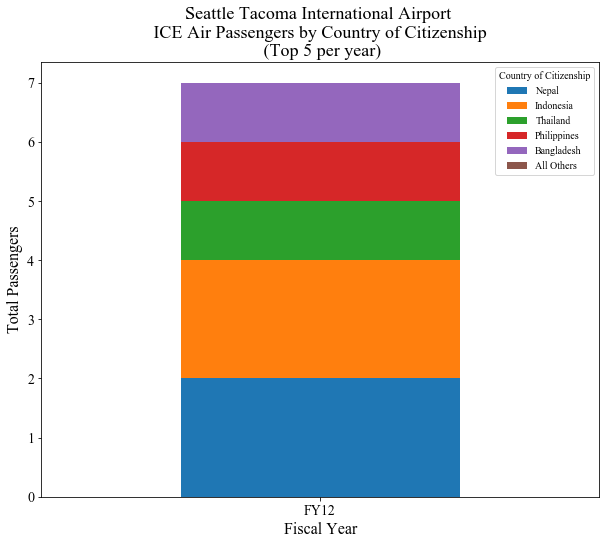

In [122]:
def country_of_citizenship_trend(data, title=str, filename=str, xlabel=str, ylabel=str):
    
    fig, ax = plt.subplots()
    
    data.plot(kind='bar', stacked=True, legend=True, ax=ax)

    ax.set_ylabel(ylabel, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_title(title, fontsize=18)
    ax.tick_params(labelsize=14)
    plt.xticks(rotation=0)

    fig.set_size_inches(10, 8)
    fig.savefig(f'../output/{filename}.png', dpi=100)
    return fig, ax

country_of_citizenship_trend(top_5_data,
                             title=f'{airport_name} \n ICE Air Passengers by Country of Citizenship \n (Top 5 per year)',
                             filename=f'{airport}_top5_nationalities',
                             ylabel='Total Passengers',
                             xlabel='Fiscal Year');

In [129]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'air2_AirportName'])['AlienMasterID','MissionID'].nunique()
drop_locs_by_year = g.reset_index()
drop_locs_by_year.rename({'MissionDate': 'FY'}, axis='columns', inplace=True)

# drop_locs_by_year.to_csv(f'../output/{airport}_drop_locs_by_year.csv', index=True)

In [131]:
pickup_df

,Status,Sex,Convictions,GangMember,ClassLvl,Age,MissionNumber,PULOC,DropLoc,StrikeFromList,...,air2_AirportID,air2_AirportName,air2_City,st2_StateID,st2_StateAbbr,aor2_AORID,aor2_AOR,aor2_AORName,air2_Country,NonCriminal
MissionDate,,,,,,,,,,,,,,,,,,,,,
2012-01-17,Removal,M,Non-Criminal,No,1.0,58.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2012-01-17,Removal,M,Non-Criminal,No,1.0,54.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2012-01-17,Removal,M,Non-Criminal,No,1.0,47.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2012-01-17,Removal,M,Rape,No,3.0,55.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2012-01-17,Removal,M,Drugs,No,2.0,38.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2012-01-17,Removal,M,Assault,No,3.0,37.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2012-01-17,Removal,M,Non-Criminal,No,1.0,38.0,120645,KSEA,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


# Alternate plot of top nationalities

Since selecting top 5 for each year is a bit counterintuitive, we can instead select here an aribtrary set of nationalities to display for all years, while summing others. This can be based on most common values or could be some other arbitrary list. (See also implementation in `global.ipynb` for plotting all values that break top 5 for any year.)

Currently set up to focus on pickups but could be reworked for dropoffs, all passengers, or removals/transfers. Remember to update corresponding chart labels.

In [88]:
annual = pickup_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()
# annual = dropoff_df.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()
# annual = airport_all.groupby([pd.Grouper(freq='AS-OCT', sort=True), 'CountryOfCitizenship'])['AlienMasterID'].nunique()

In [89]:
# There is probably a better way to do this
annual = annual.reset_index()
annual.set_index('MissionDate', inplace=True)

In [90]:
top6 = list(annual.groupby(['CountryOfCitizenship'])['AlienMasterID'].sum().sort_values(ascending=False).head(6).index)

top_6_df = pd.DataFrame()
top_6_df = top_6_df.append(annual[annual['CountryOfCitizenship'].isin(top6)])
top_6_df.index = top_6_df.index.year

for year in annual.index.year.unique():
    temp = annual[f'{year}']
    temp2 = temp[~temp['CountryOfCitizenship'].isin(top6)]
    all_other_count = temp2['AlienMasterID'].sum()
    other_df = pd.DataFrame([['ALL OTHERS', all_other_count]],
                            columns=['CountryOfCitizenship',
                                     'AlienMasterID'],
                            index=[year])
    top_6_df = top_6_df.append(other_df)

top_6_df.sort_index(inplace=True)
top_6_df.index = [f'FY{str(x)[2:4]}' for x in top_6_df.index + 1]

top_6_df['CountryOfCitizenship'] = top_6_df['CountryOfCitizenship'].astype('category')

top_6_data = pd.pivot_table(data=top_6_df,
                       index=top_6_df.index,
                       columns='CountryOfCitizenship',
                       values='AlienMasterID',
                       aggfunc=np.sum,
                       fill_value=0)
top_6_data = top_6_data.reindex(top_6_data.sum().sort_values(ascending=False).index, axis=1)
cols = list(top_6_data.columns)
cols.remove('ALL OTHERS')
cols.append('ALL OTHERS')
top_6_data = top_6_data[cols]

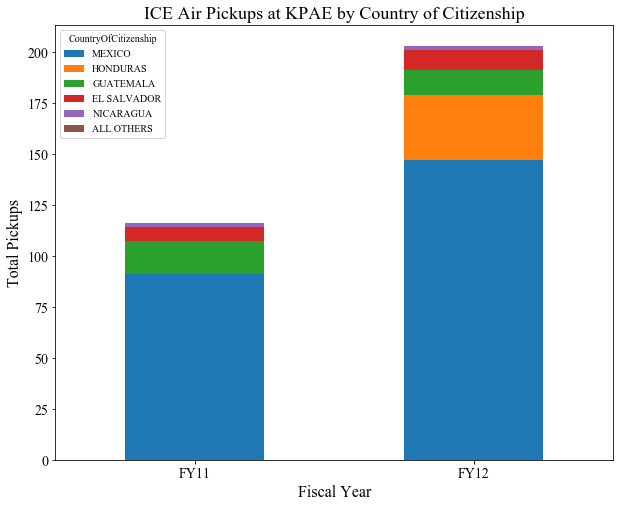

In [91]:
country_of_citizenship_trend(top_6_data,
                             title=f'ICE Air Pickups at {airport} by Country of Citizenship',
                             filename=f'{airport}_pickup_nationalities',
                             ylabel='Total Pickups',
                             xlabel='Fiscal Year');

# Juveniles (by fiscal year)

Table of just juveniles for pickups, dropoffs. Currently will fail if no juveniles.

In [92]:
assert sum(all_df['Juvenile']) > 0, f"No juveniles in dataset for {airport}"

AssertionError: No juveniles in dataset for KPAE

In [93]:
g = pickup_df.groupby(['PULOC', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

KeyError: True

In [94]:
g = dropoff_df.groupby(['DropLoc', pd.Grouper(freq='AS-OCT', sort=True), 'Juvenile'])['AlienMasterID'].nunique()
juvenile_pickups = g.unstack()

In [95]:
juvenile_pickups

Juvenile             False
DropLoc MissionDate       
KPAE    2010-10-01      16
        2011-10-01       3

In [96]:
juvenile_pickups['percent'] = juvenile_pickups[True] / juvenile_pickups[False] * 100
juvenile_pickups

KeyError: True